In [1]:
import sys
import os
from pathlib import Path
sys.path.append(os.path.join(Path.home(), 'QUIC-Projects'))
sys.path


['/home/quic/QUIC-Projects/summary_ipynb',
 '/home/quic/.vscode-server/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles/vscode_datascience_helpers/../.does-not-exist',
 '/home/quic/.vscode-server/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles',
 '/home/quic/.vscode-server/extensions/ms-toolsai.jupyter-2020.12.414227025/pythonFiles/lib/python',
 '/home/quic/anaconda3/envs/quic/lib/python38.zip',
 '/home/quic/anaconda3/envs/quic/lib/python3.8',
 '/home/quic/anaconda3/envs/quic/lib/python3.8/lib-dynload',
 '',
 '/home/quic/anaconda3/envs/quic/lib/python3.8/site-packages',
 '/home/quic/anaconda3/envs/quic/lib/python3.8/site-packages/IPython/extensions',
 '/home/quic/.ipython',
 '/home/quic/QUIC-Projects']

In [2]:
import torch
from torch import tensor
from torch.nn import HingeEmbeddingLoss
from torch.utils.data import DataLoader

from sklearn.svm import SVC

from custom_qiskit_v3.datageneration import Sklearn_Dataset
from custom_qiskit_v3.classifier import SVM

import numpy as np 
from matplotlib import pyplot as plt

In [3]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

In [4]:
labels=(1,2)
ds = Sklearn_Dataset('iris', device=device, labels=labels)
dl = DataLoader(ds, batch_size=2**6, shuffle=True)
Xy = tuple(dl)[0]
X = Xy[0]
y = torch.empty_like(Xy[1])
y[Xy[1]<np.mean(labels)]=-1
y[Xy[1]>=np.mean(labels)]=1
Xtyt = tuple(dl)[1]
Xt = Xtyt[0]
yt = torch.empty_like(Xtyt[1])
yt[Xtyt[1]<np.mean(labels)]=-1
yt[Xtyt[1]>=np.mean(labels)]=1

In [5]:
class LossFN_SVM(torch.nn.Module):
    def __init__(self, X, y, kernel):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.alpha = torch.nn.Parameter(torch.randn(len(y)))
        self.bias = torch.nn.Parameter(torch.randn(()))
        self.X = X
        self.y = y
        self.kernel = kernel

    def forward(self, X):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        return ((self.alpha*self.y) @ self.kernel(self.X, X))+self.bias
        

In [6]:
def HingeLoss(input, target):
    return torch.sum(torch.max(torch.zeros(input.shape, device=device), 1-input*target))

In [7]:
def RBF_Kernel(X:torch.Tensor, Y:torch.Tensor, gamma:float=1):
    return torch.exp(-gamma/2*torch.norm(X-Y).pow(2))

def RBF_Kernel_Matrix(X, Y):
    mat = torch.empty(len(X), len(Y), device=device)
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            mat[i, j] = RBF_Kernel(X[i], Y[j])
    return mat

In [8]:
mdl = LossFN_SVM(X, y, RBF_Kernel_Matrix).to(device)

In [9]:
loss_fn = HingeLoss
optimizer = torch.optim.Adam(mdl.parameters(), lr=1e-5)
dataloader = DataLoader(ds, batch_size=2, shuffle=True)
epochs = 1000
for epoch in range(epochs):
    loss = loss_fn(mdl(X), y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%100==0:
        print(loss.item())

112.02959442138672


KeyboardInterrupt: 

In [10]:
with torch.no_grad():
    print(sum(mdl.alpha*mdl.y))

tensor(2.6687)


In [11]:
RBF_Kernel_Matrix(X, X[0:2]).shape

torch.Size([64, 2])

In [12]:
with torch.no_grad():
    print(sum(np.sign(mdl(Xt).numpy())==yt.numpy())/len(yt))

0.7222222222222222


In [26]:
from custom_qiskit_v3.datageneration import Sklearn_Dataset
from custom_qiskit_v3.classifier import SVM, Pow2_kernel, linear_kernel, RBF_kernel

labels=(0, 1)
ds = Sklearn_Dataset('iris', device=torch.device('cpu'), labels=labels)
dl = DataLoader(ds, batch_size=2**6, shuffle=True)
Xy = tuple(dl)[0]
X = Xy[0]
y = torch.empty_like(Xy[1])
y[Xy[1]<np.mean(labels)]=-1
y[Xy[1]>=np.mean(labels)]=1
Xtyt = tuple(dl)[1]
Xt = Xtyt[0]
yt = torch.empty_like(Xtyt[1])
yt[Xtyt[1]<np.mean(labels)]=-1
yt[Xtyt[1]>=np.mean(labels)]=1

In [27]:
X = np.array( X.numpy(), dtype=float)
y = np.array( y.numpy(), dtype=float)
Xt =  np.array(Xt.numpy(), dtype=float)
yt =  np.array(yt.numpy(), dtype=float)

In [34]:
svm = SVM(X, y, 1000)
svm.optimize(linear_kernel, 1, 'qsvm')

In [35]:
svm.accuracy(Xt, yt)

1.0

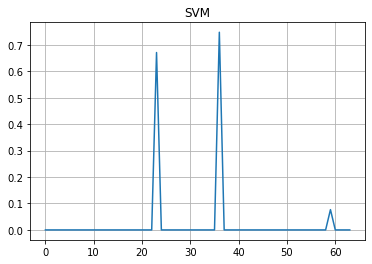

In [36]:
Xe = svm.tsne(50)
svm.data_emb = Xe
svm.plot('alpha')

In [2]:
import multiprocessing as mp 
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from custom_qiskit_v3.classifier import SVM, Pow2_kernel, RBF_kernel, linear_kernel
from tqdm.notebook import tqdm
from custom_qiskit_v3.datageneration import Sklearn_Dataset
from custom_qiskit_v3_1.datageneration import Sklearn_DataLoader

def f(C):
    labels=(0,2)
    #X, y, Xt, yt = Sklearn_Dataset('iris', labels=labels, device=torch.device('cpu')).get_sets(2**6, shuffle=True)
    dl = Sklearn_DataLoader('iris', labels=None, mean=0)
    X, y, Xt, yt = dl(2**6, 2)

    svm1 = SVM(X, y, C=C)
    svm1.optimize(Pow2_kernel, None, 'svm')
    svm2 = SVM(X, y, C=C)
    svm2.optimize(Pow2_kernel, None, 'qsvm')
    svm3 = SVM(X, y, C=None)
    svm3.optimize(Pow2_kernel, None, 'svm')
    return [C, svm1.accuracy(Xt, yt), svm2.accuracy(Xt, yt), svm3.accuracy(Xt, yt)]

Cs = np.array([np.logspace(-4, 4, 100) for _ in range(100)]).reshape(-1)
if __name__=='__main__':
    with mp.Pool(processes=mp.cpu_count()) as pool:
        res = list(tqdm(pool.imap_unordered(f, tuple(Cs)), total=Cs.size))
res = sorted(res, key=lambda x:x[0])

a = np.array(np.array_split(res, 100))
err_mean = 1-a.mean(axis=1)[:, 1:5]
err_std = a.std(axis=1)[:, 1:5]
C = a.mean(axis=1)[:,0]

ValueError: domain error

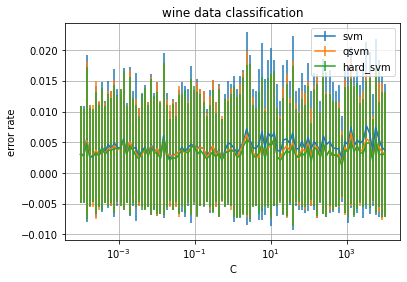

In [5]:
import matplotlib.pyplot as plt
plt.errorbar(C[:], err_mean[:, 0], yerr=err_std[:, 0], label='svm')
plt.errorbar(C[:], err_mean[:, 1], yerr=err_std[:, 1], label='qsvm')
plt.errorbar(C[:], err_mean[:, 2], yerr=err_std[:, 2], label='hard_svm')
plt.xscale('log')

plt.grid()
plt.legend()
plt.xlabel('C')
plt.ylabel('error rate')
plt.title('iris data classification')
plt.show()

-1